In [1]:
from utils import *
from methods import *
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

RAND_SEED = 251289


C:\Users\hoang\anaconda3\envs\proj_251b_289a_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameter Sweeping

In [3]:
# Decision tree for all circuits
RAND_SEED = 251289
circuit_names = ["32-bit 2-input ALU", "64-bit 2-input ALU", "32-bit 2-input MUX", 'BCD to 7-seg decoder']
circuits = ["alu32", "alu64", "mux32", "7sg"]
lambdas = [1e12, 1e11, 1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]

best_lambda_ridge = []
best_lambda_lasso = []

NRMSE = {
    "Least-Squares": [], 
    "Ridge Regression": [], 
    "LASSO": []
}

best_lambda = {
    "Ridge Regression": [], 
    "LASSO": []
}

training_NRMSE_all_lambdas = {
    "Ridge Regression": [], 
    "LASSO": []
}

validation_NRMSE_all_lambdas = {
    "Ridge Regression": [], 
    "LASSO": []
}

for id, circuit in enumerate(circuits):
    print('Circuit: ', circuit)
    validation_NRMSE_ridge = []
    validation_NRMSE_lasso = []
    train_NRMSE_ridge = []
    train_NRMSE_lasso = []

    X_train, X_validation, y_train, y_validation, features = load_and_split_dataset(file=f"dataset/processed_power_data_{circuit}.mat", 
                                                                                validation_size=0.2,
                                                                                RAND_SEED = RAND_SEED)

    reg = LinearRegression().fit(X_train, y_train)
    y_hat = reg.predict(X_validation)
    NRMSE["Least-Squares"].append( get_NRMSE(y_validation, y_hat) )

    for l in lambdas:
        reg = Ridge(alpha=l).fit(X_train, y_train)
        y_hat = reg.predict(X_validation)
        validation_NRMSE_ridge.append( get_NRMSE(y_validation, y_hat) )
        train_NRMSE_ridge.append( get_NRMSE(y_train, reg.predict(X_train)) )

        reg = Lasso(alpha=l).fit(X_train, y_train)
        y_hat = reg.predict(X_validation)
        validation_NRMSE_lasso.append( get_NRMSE(y_validation, y_hat) )
        train_NRMSE_lasso.append( get_NRMSE(y_train, reg.predict(X_train)) )

    validation_NRMSE_all_lambdas["Ridge Regression"].append(validation_NRMSE_ridge)
    validation_NRMSE_all_lambdas["LASSO"].append(validation_NRMSE_lasso)
    training_NRMSE_all_lambdas["Ridge Regression"].append(train_NRMSE_ridge)
    training_NRMSE_all_lambdas["LASSO"].append(train_NRMSE_lasso)

    best_lambda["Ridge Regression"].append(lambdas[np.argmin(validation_NRMSE_ridge)])
    NRMSE["Ridge Regression"].append(np.min(validation_NRMSE_ridge))
    best_lambda["LASSO"].append(lambdas[np.argmin(validation_NRMSE_lasso)])
    NRMSE["LASSO"].append(np.min(validation_NRMSE_lasso))

Circuit:  alu32
Circuit:  alu64
Circuit:  mux32
Circuit:  7sg


In [4]:
print(best_lambda)
print(NRMSE)

{'Ridge Regression': [1e-12, 10.0, 1e-11, 10.0], 'LASSO': [1000000000000.0, 1000000000000.0, 1000000000000.0, 1000000000000.0]}
{'Least-Squares': [0.027465869469751665, 0.11279824896936623, 0.014638091569526066, 0.03051938491940053], 'Ridge Regression': [0.027465869469751686, 0.11249304660353418, 0.01463809156952607, 0.03046865569912494], 'LASSO': [6.17822016300993, 6.9559739455404905, 5.31095163332601, 4.739193005080572]}


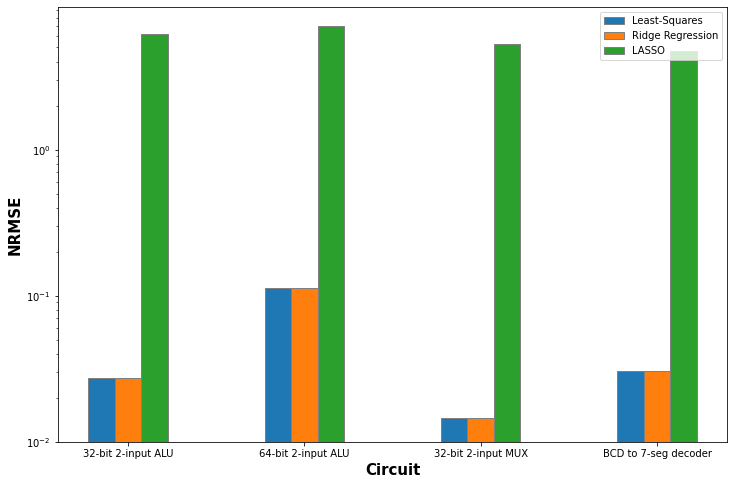

In [5]:
num_circuits = len(circuit_names)

# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize=(12, 8))
 
# Set position of bar on X axis
br = []
for id, (model, error) in enumerate(NRMSE.items()):
    if id == 0:
        br.append(np.arange(num_circuits))
    else:
        br.append( [x + barWidth for x in br[id-1]] )

    # Make the plot
    plt.bar(br[id], error, width=barWidth, edgecolor='grey', label=model)

# Adding Xticks
plt.xlabel('Circuit', fontweight='bold', fontsize=15)
plt.ylabel('NRMSE', fontweight='bold', fontsize=15)
plt.xticks([r + 1*barWidth for r in range(num_circuits)], circuit_names)
plt.yscale('log')
# plt.yticks(np.arange(np.min(sum(NRMSE.values(), [])), np.max(sum(NRMSE.values(), []))+1, 1))
plt.yticks([0.01, 0.1, 1])
plt.legend()
plt.savefig("images/linear_regression.png")

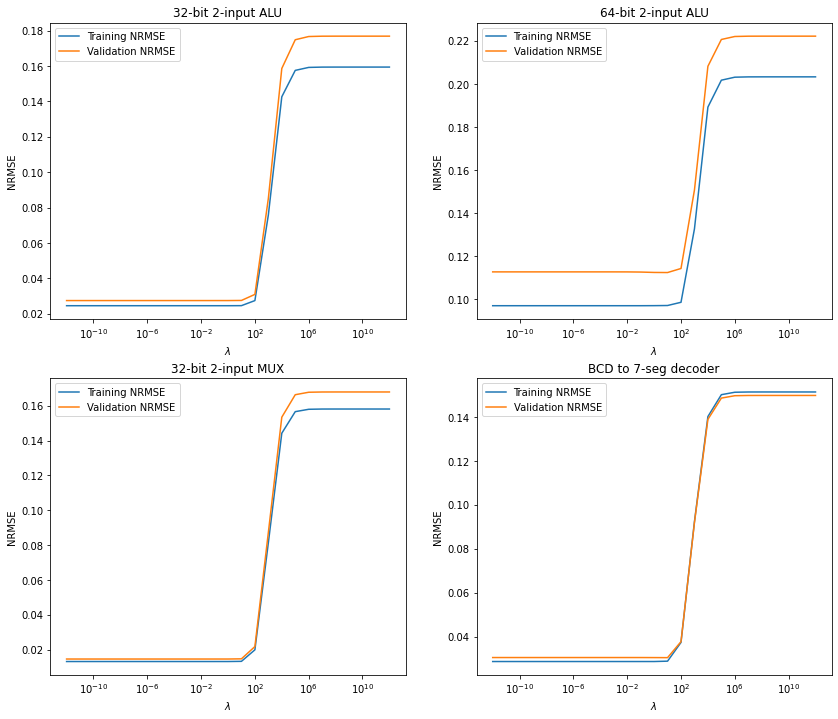

In [26]:
fig = plt.figure(figsize=(14,12))

ax = [0, 0, 0, 0]
ax[0] = fig.add_subplot(221)
ax[1] = fig.add_subplot(222)
ax[2] = fig.add_subplot(223)
ax[3] = fig.add_subplot(224)

for id, circuit in enumerate(circuits):
    ax[id].plot(lambdas, training_NRMSE_all_lambdas["Ridge Regression"][id], label='Training NRMSE')
    ax[id].plot(lambdas, validation_NRMSE_all_lambdas["Ridge Regression"][id], label='Validation NRMSE')
    ax[id].set_xlabel("$\lambda$")
    ax[id].set_ylabel("NRMSE")
    ax[id].set_xscale('log')
    ax[id].set_title(circuit_names[id])
    ax[id].legend()

plt.savefig("images/linear_regression/ridge_regression_sweep.png")

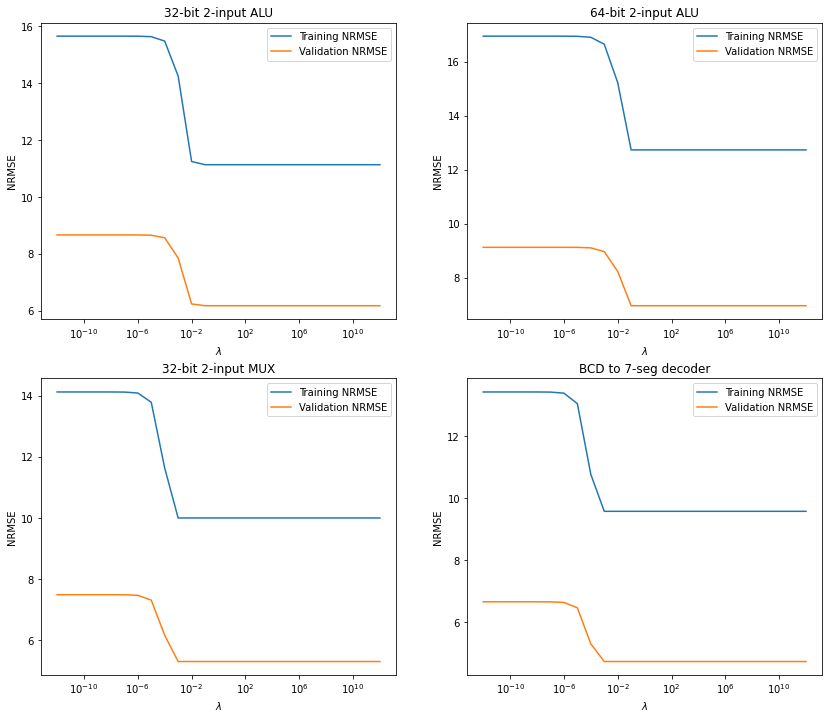

In [32]:
fig = plt.figure(figsize=(14,12))

ax = [0, 0, 0, 0]
ax[0] = fig.add_subplot(221)
ax[1] = fig.add_subplot(222)
ax[2] = fig.add_subplot(223)
ax[3] = fig.add_subplot(224)

for id, circuit in enumerate(circuits):
    ax[id].plot(lambdas, training_NRMSE_all_lambdas["LASSO"][id], label='Training NRMSE')
    ax[id].plot(lambdas, validation_NRMSE_all_lambdas["LASSO"][id], label='Validation NRMSE')
    ax[id].set_xlabel("$\lambda$")    
    ax[id].set_ylabel("NRMSE")
    ax[id].set_xscale('log')
    ax[id].set_title(circuit_names[id])
    ax[id].legend()

plt.savefig("images/linear_regression/lasso_sweep.png")

## Testing

In [ ]:
# BRUTE FORCE

# Least-squares linear regression
from numpy.linalg import pinv

X_train, X_validation, y_train, y_validation, features = load_and_split_dataset()

b = 1 # bias term

# Add fictitious dimention for bias term
X_train = np.hstack([X_train, b*np.ones(X_train.shape[0]).reshape(-1, 1)])
X_validation = np.hstack([X_validation, b*np.ones(X_validation.shape[0]).reshape(-1, 1)])

# Fit
w = pinv(X_train) @ y_train # trained weights

# Make predictions and compute error
y_hat_train = X_train @ w
y_hat_validation = X_validation @ w

print('Training Error: ', get_NRMSE(y=y_train, y_hat=y_hat_train))
print('Validation Error: ', get_NRMSE(y=y_validation, y_hat=y_hat_validation))

# Ridge regression
from numpy.linalg import inv

X_train, X_validation, y_train, y_validation, features = load_and_split_dataset()

l = 0.005 # regularization term (lambda)
b = 1 # bias term

# Add fictitious dimention for bias term
X_train = np.hstack([X_train, b*np.ones(X_train.shape[0]).reshape(-1, 1)])
X_validation = np.hstack([X_validation, b*np.ones(X_validation.shape[0]).reshape(-1, 1)])

# Fit
I_prime = np.identity(X_train.shape[1])
I_prime[-1,-1] = 0
w = inv(X_train.T @ X_train + l*I_prime) @ X_train.T @ y_train # trained weights

# Make predictions and compute error
y_hat_train = X_train @ w
y_hat_validation = X_validation @ w

print('Training Error: ', get_NRMSE(y=y_train, y_hat=y_hat_train))
print('Validation Error: ', get_NRMSE(y=y_validation, y_hat=y_hat_validation))


In [ ]:
# Least-squares linear regression
X_train, X_validation, y_train, y_validation, features = load_and_split_dataset()
reg = LinearRegression().fit(X_train, y_train)
y_hat_train = reg.predict(X_train)
y_hat_validation = reg.predict(X_validation)

print('Training Error: ', get_NRMSE(y=y_train, y_hat=y_hat_train))
print('Validation Error: ', get_NRMSE(y=y_validation, y_hat=y_hat_validation))

In [ ]:
# Ridge regression
X_train, X_validation, y_train, y_validation, features = load_and_split_dataset()

# Hyper-parameters
lambdas = [1e12, 1e11, 1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]

for l in lambdas:
    reg = Ridge(alpha=l).fit(X_train, y_train)
    y_hat_train = reg.predict(X_train)
    y_hat_validation = reg.predict(X_validation)

    print('Training Error: ', get_NRMSE(y=y_train, y_hat=y_hat_train))
    print('Validation Error: ', get_NRMSE(y=y_validation, y_hat=y_hat_validation))

In [ ]:
# Lasso regression
X_train, X_validation, y_train, y_validation, features = load_and_split_dataset()

# Hyper-parameters
lambdas = [1e12, 1e11, 1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]

for l in lambdas:
    reg = Lasso(alpha=l).fit(X_train, y_train)
    y_hat_train = reg.predict(X_train)
    y_hat_validation = reg.predict(X_validation)

    print('Training Error: ', get_NRMSE(y=y_train, y_hat=y_hat_train))
    print('Validation Error: ', get_NRMSE(y=y_validation, y_hat=y_hat_validation))